Ingeniería de Características: Creación de Nuevas Variables (Core)

Descripción:
En esta actividad, trabajarás con el dataset «Titanic – Machine Learning from Disaster» disponible en Kaggle para realizar ingeniería de características. El objetivo es crear nuevas variables a partir de las existentes y evaluar cómo estas nuevas características pueden mejorar la capacidad predictiva de un modelo de machine learning.

Objetivo:

El objetivo principal es desarrollar habilidades en la creación de nuevas variables que capturen información útil no presente en las variables originales. Estas nuevas características serán utilizadas para mejorar el rendimiento de un modelo de clasificación que prediga la supervivencia de los pasajeros del Titanic.


# 1. Carga de datos:

* Descarga y carga el dataset «Titanic» desde Kaggle. Realiza una exploración inicial de las variables disponibles, que incluyen información sobre la edad, el género, la clase del pasajero, entre otros.
* Examina cuántos valores faltan en las variables importantes como la edad y el precio del boleto.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2,mutual_info_classif,f_classif
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [37]:
# cargar el dataset
data = pd.read_csv('../data/traintitanic.csv')
test = pd.read_csv('../data/testtitanic.csv')
test_mod = pd.read_csv('../data/testtitanic.csv')

In [38]:
print(data.shape)
print(data.columns)
data.info()
data.head(5)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
# Manejo de valores faltantes adecuadamente: 
qsna=data.shape[0]-data.isnull().sum(axis=0)
qna=data.isnull().sum(axis=0)
ppna=round(100*(data.isnull().sum(axis=0)/data.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Cabin,204,687,77.10
Age,714,177,19.87
Embarked,889,2,0.22
PassengerId,891,0,0.00
Survived,891,0,0.00
Pclass,891,0,0.00
Name,891,0,0.00
Sex,891,0,0.00
SibSp,891,0,0.00
Parch,891,0,0.00


# 2. Exploración y preprocesamiento de datos:
* Realiza una limpieza de los datos, manejando los valores nulos. Por ejemplo, puedes imputar los valores faltantes de la edad con la mediana o la media según sea conveniente.
* Revisa la distribución de las variables y asegúrate de que las categorías estén codificadas correctamente para el modelado.

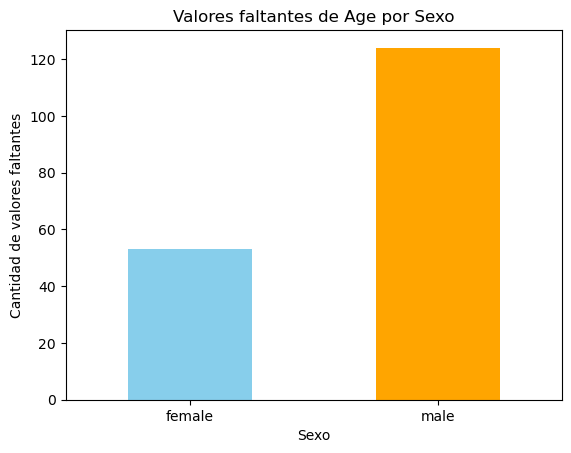

In [40]:
# Crear una columna que indique si el valor en 'Age' está faltando
data['Age_missing'] = data['Age'].isnull()

# Contar valores faltantes de 'Age' por cada categoría de 'Sex'
missing_by_sex = data.groupby('Sex')['Age_missing'].sum()

# Graficar los valores faltantes por 'Sex'
missing_by_sex.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Valores faltantes de Age por Sexo')
plt.ylabel('Cantidad de valores faltantes')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
plt.show()

In [41]:
# Teniendo en cuenta que era prioridad rescatar mujeres y niños, la edad de las mujeres no es tan relevante por lo que
# puede imputarse por la media

# Calcular la media de 'Age' para el género femenino (ignorando valores faltantes)
mean_female_age = data.loc[data['Sex'] == 'female', 'Age'].mean()

# Llenar valores faltantes de 'Age' solo para las filas donde 'Sex' es femenino
data.loc[(data['Sex'] == 'female') & (data['Age'].isnull()), 'Age'] = mean_female_age

# Verificar que ya no haya valores faltantes para las mujeres en 'Age'
missing_female_age = data.loc[data['Sex'] == 'female', 'Age'].isnull().sum()
print(f"Valores faltantes de 'Age' para el género femenino: {missing_female_age}")

qsna=data.shape[0]-data.isnull().sum(axis=0)
qna=data.isnull().sum(axis=0)
ppna=round(100*(data.isnull().sum(axis=0)/data.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

Valores faltantes de 'Age' para el género femenino: 0


,datos sin NAs en q,Na en q,Na en %
Cabin,204,687,77.10
Age,767,124,13.92
Embarked,889,2,0.22
PassengerId,891,0,0.00
Survived,891,0,0.00
Pclass,891,0,0.00
Name,891,0,0.00
Sex,891,0,0.00
SibSp,891,0,0.00
Parch,891,0,0.00


In [42]:
# Eliminar la columna 'Cabin'
data.drop(columns=['Cabin'], inplace=True)

# Eliminar las filas con valores nulos restantes
data.dropna(inplace=True)

# Verificar si quedan valores nulos
print(data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Age_missing    0
dtype: int64


In [43]:
def convert_object_to_category(data):
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = data[col].astype('category')
    return data

# Usando la función en tu dataset
data = convert_object_to_category(data)
test = convert_object_to_category(test)
test_mod = convert_object_to_category(test_mod)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  765 non-null    int64   
 1   Survived     765 non-null    int64   
 2   Pclass       765 non-null    int64   
 3   Name         765 non-null    category
 4   Sex          765 non-null    category
 5   Age          765 non-null    float64 
 6   SibSp        765 non-null    int64   
 7   Parch        765 non-null    int64   
 8   Ticket       765 non-null    category
 9   Fare         765 non-null    float64 
 10  Embarked     765 non-null    category
 11  Age_missing  765 non-null    bool    
dtypes: bool(1), category(4), float64(2), int64(5)
memory usage: 96.1 KB


# 3. Creación de nuevas características:

In [44]:
# Crear la columna 'FamilySize' como la suma de 'SibSp', 'Parch' y 1 (incluye al pasajero)
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
test_mod['FamilySize'] = test_mod['SibSp'] + test_mod['Parch'] + 1

# Verificar los primeros registros de la nueva columna
print(data[['SibSp', 'Parch', 'FamilySize']].head())

   SibSp  Parch  FamilySize
0      1      0           2
1      1      0           2
2      0      0           1
3      1      0           2
4      0      0           1


In [45]:
# Crear la nueva columna 'AgeGroup' basada en rangos de edad
data['AgeGroup'] = pd.cut(
    data['Age'],
    bins=[0, 10, 18, 60, float('inf')],  # Límites de los rangos
    labels=['Niños', 'Adolescentes', 'Adultos', 'Adultos mayores'],  # Etiquetas
    right=False  # Intervalos cerrados a la izquierda
)
test_mod['AgeGroup'] = pd.cut(
    data['Age'],
    bins=[0, 10, 18, 60, float('inf')],  # Límites de los rangos
    labels=['Niños', 'Adolescentes', 'Adultos', 'Adultos mayores'],  # Etiquetas
    right=False  # Intervalos cerrados a la izquierda
)

# Verificar los primeros registros de la nueva columna
print(data[['Age', 'AgeGroup']].head())

    Age AgeGroup
0  22.0  Adultos
1  38.0  Adultos
2  26.0  Adultos
3  35.0  Adultos
4  35.0  Adultos


In [46]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  765 non-null    int64   
 1   Survived     765 non-null    int64   
 2   Pclass       765 non-null    int64   
 3   Name         765 non-null    category
 4   Sex          765 non-null    category
 5   Age          765 non-null    float64 
 6   SibSp        765 non-null    int64   
 7   Parch        765 non-null    int64   
 8   Ticket       765 non-null    category
 9   Fare         765 non-null    float64 
 10  Embarked     765 non-null    category
 11  Age_missing  765 non-null    bool    
 12  FamilySize   765 non-null    int64   
 13  AgeGroup     765 non-null    category
dtypes: bool(1), category(5), float64(2), int64(6)
memory usage: 119.2 KB


# 4. Evaluación de nuevas características:

## Dataset original

In [47]:
train = pd.read_csv('../data/traintitanic.csv')

# Separar características (X) y objetivo (y)
X = train.drop(columns=['Survived','Name', 'Ticket','PassengerId']) 
y = train['Survived']

# Identificar columnas numéricas y categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['category']).columns

# Crear un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # Escalado para columnas numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Codificación para categóricas
    ]
)

# Crear un pipeline con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Dividir los datos de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir en validación
y_pred_val = pipeline.predict(X_val)

# Calcular métricas
accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

print(f"Exactitud en validación: {accuracy:.2f}")
print(f"F1-Score en validación: {f1:.2f}")

# Aplicar al conjunto de prueba
X_test = test.copy()
X_test.fillna(method='ffill', inplace=True)  # Llena valores nulos en el conjunto de prueba
test['Survived'] = pipeline.predict(X_test)

# Guardar resultados
test.to_csv('test_predictions.csv', index=False)

Exactitud en validación: 0.73
F1-Score en validación: 0.66


C:\Users\IK\AppData\Local\Temp\ipykernel_6668\3217604105.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method='ffill', inplace=True)  # Llena valores nulos en el conjunto de prueba


## Dataset personalizado

In [49]:
# Separar características (X) y objetivo (y)
X = data.drop(columns=['Survived','Pclass', 'Name', 'Ticket','PassengerId', 'Age_missing']) 
y = data['Survived']

# Identificar columnas numéricas y categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['category']).columns

# Crear un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # Escalado para columnas numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Codificación para categóricas
    ]
)

# Crear un pipeline con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Dividir los datos de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir en validación
y_pred_val = pipeline.predict(X_val)

# Calcular métricas
accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

print(f"Exactitud en validación: {accuracy:.2f}")
print(f"F1-Score en validación: {f1:.2f}")

# Aplicar al conjunto de prueba
X_test = test_mod.copy()
X_test.fillna(method='ffill', inplace=True)  # Llena valores nulos en el conjunto de prueba
test['Survived'] = pipeline.predict(X_test)

# Guardar resultados
test_mod.to_csv('test_predictions.csv', index=False)

Exactitud en validación: 0.82
F1-Score en validación: 0.77


C:\Users\IK\AppData\Local\Temp\ipykernel_6668\2510961181.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method='ffill', inplace=True)  # Llena valores nulos en el conjunto de prueba


# 5. Interpretación de los resultados:

* Se obtuvo una precision y una f1 score mejor en el modelo que incluye las nuevas columnas creadas, esto significa que 
estas nuevas caracteristicas influyeron positivamente en la prediccion ayudando al modelo a capter mejor las relaciones
entre las variables